# Starter Pack

In [11]:
import numpy as np
import matplotlib.pyplot as plt

dataset = np.loadtxt('clean_dataset.txt')
noisy_dataset = np.loadtxt('noisy_dataset.txt')

## Some utils sub functions

Compute the entropy of a dataset : will be usefull in the split function

In [12]:
def compute_entropy(dataset):
    unique, counts = np.unique(dataset[:, 7], return_counts=True)
    entropy = 0
    n = dataset[:, 7].shape[0]
    for id, label in enumerate(unique):
        probability = counts[id] / n
        entropy -= probability * np.log2(probability)
    return entropy

print("The entropy of the clean dataset is:", compute_entropy(dataset))

The entropy of the clean dataset is: 2.0


As we will very often split datasets in the future, we design two little sub functions to make things clearer in the main function

In [13]:
def split_dataset(dataset, idx):
    return dataset[:idx, :], dataset[idx:, :]

# Extract a part (from start_index and of len length) and returns the extract and the remaining array
def extract_from_array(full_array, start_index, length):
    left_part, tmp = split_dataset(full_array, start_index)
    extract, right_part = split_dataset(tmp, length)
    remaining = np.concatenate((left_part, right_part))
    return extract, remaining

print("The extract of the samples between lines 20 and 30 of the full dataset is: ")
print(extract_from_array(dataset,20,10)[0])
print(" The remaining dataset is of shape: ", extract_from_array(dataset,20,10)[1].shape )

The extract of the samples between lines 20 and 30 of the full dataset is: 
[[-63. -59. -64. -66. -72. -84. -90.   1.]
 [-65. -59. -66. -65. -68. -82. -85.   1.]
 [-63. -56. -63. -65. -72. -82. -89.   1.]
 [-67. -60. -66. -65. -75. -86. -87.   1.]
 [-63. -57. -67. -66. -79. -86. -89.   1.]
 [-66. -59. -64. -68. -68. -97. -83.   1.]
 [-65. -61. -64. -68. -77. -86. -89.   1.]
 [-66. -57. -65. -69. -78. -85. -85.   1.]
 [-67. -57. -64. -71. -75. -89. -87.   1.]
 [-65. -62. -62. -65. -77. -84. -85.   1.]]
 The remaining dataset is of shape:  (1990, 8)


## The split function

Here, we design a function find_split, which chooses the attribute and the value that results in the highest information gain when splitting a dataset on a node of the tree.

In [14]:
def find_split(full_dataset):
    # Start by evaluating the entropy of the full dataset
    entropy_full = compute_entropy(full_dataset)
    n = full_dataset.shape[0]
    best_feature, best_value, best_gain = 0, 0, 0
    # We will evaluate every possible split in each of the 7 features
    for feature in range(7):
        # We start by sorting the dataset in ascending order on the current feature 
        sorted_dataset = full_dataset[full_dataset[:, feature].argsort()]
        minval, maxval = sorted_dataset[0][feature], sorted_dataset[-1][feature]
        # We discard the features containing the same value for all samples (can lead to wrong splits)
        if minval == maxval:
            continue
        for idx in range(len(sorted_dataset[:, feature])):
            # Split the data on the current index
            data_left, data_right = split_dataset(sorted_dataset, idx)
            # Evaluate the entropy of each sub dataset
            entropy_left, entropy_right = compute_entropy(data_left), compute_entropy(data_right)
            # Compute the resulting gain of such a split
            gain = entropy_full - ((data_left.shape[0]/n)*entropy_left + (data_right.shape[0]/n)*entropy_right)
            # If this is the best split so far, we keep track of its characteristics 
            if gain > best_gain:
                best_feature = feature
                best_gain = gain
                if sorted_dataset[idx, feature] == minval:
                    # Avoid the case where the split point is at the edge of the dataset (and thus we could not split)
                    best_value = sorted_dataset[idx, feature] + 0.5
                elif sorted_dataset[idx, feature] == maxval:
                    best_value = sorted_dataset[idx, feature] - 0.5
                else:
                    best_value = sorted_dataset[idx, feature]
    return best_feature, best_value

## The "training" algorithm: building of the decision tree from the dataset

Thanks to the previous sub functions, we can now implement the recursive function decision_tree_learning() to create the decision trees based on the given pseudo-code.

In [15]:
def decision_tree_learning(data, depth):
    # If there's only one label on the current dataset, we have found a leaf of the tree
    if len(np.unique(data[:, 7])) == 1:
        terminal_node = {'attr': 'leaf', 'value': data[0, 7], 'left': {}, 'right': {}}
        return terminal_node, depth
    else:
        attr, val = find_split(data)
        # Get a "mask" (array of booleans which are the results of the arithmetic test on the array elements)
        mask_less = data[:, attr] <= val
        mask_more = data[:, attr] > val
        l_dataset = data[mask_less]
        r_dataset = data[mask_more]
        # Recursively build the tree
        l_branch, l_depth = decision_tree_learning(l_dataset, depth + 1)
        r_branch, r_depth = decision_tree_learning(r_dataset, depth + 1)
        node = {'attr': attr, 'value': val, 'left': l_branch, 'right': r_branch}
        return node, max(l_depth, r_depth)

In [16]:
trained_tree_clean_dataset = decision_tree_learning(dataset, 0)
print("The decision tree built from the full clean dataset is as follows: ")
trained_tree_clean_dataset[0]

The decision tree built from the full clean dataset is as follows: 


{'attr': 0,
 'value': -54.0,
 'left': {'attr': 4,
  'value': -59.0,
  'left': {'attr': 3,
   'value': -56.0,
   'left': {'attr': 4,
    'value': -64.0,
    'left': {'attr': 4,
     'value': -64.5,
     'left': {'attr': 'leaf', 'value': 1.0, 'left': {}, 'right': {}},
     'right': {'attr': 2,
      'value': -54.0,
      'left': {'attr': 2,
       'value': -54.5,
       'left': {'attr': 'leaf', 'value': 1.0, 'left': {}, 'right': {}},
       'right': {'attr': 0,
        'value': -60.5,
        'left': {'attr': 'leaf', 'value': 1.0, 'left': {}, 'right': {}},
        'right': {'attr': 'leaf', 'value': 4.0, 'left': {}, 'right': {}}}},
      'right': {'attr': 0,
       'value': -56.5,
       'left': {'attr': 'leaf', 'value': 1.0, 'left': {}, 'right': {}},
       'right': {'attr': 'leaf', 'value': 3.0, 'left': {}, 'right': {}}}}},
    'right': {'attr': 2,
     'value': -52.0,
     'left': {'attr': 1,
      'value': -58.0,
      'left': {'attr': 0,
       'value': -60.0,
       'left': {'attr':

In [17]:
def plot_graph_dot(tree, x=0, y=0, depth=0, max_depth=None):
    # Parameters (spaces between nodes, and box format)
    bbox_parameters = dict(boxstyle="round,pad=0.3", fc="white", ec="black")
    delta_x = 1/(2**depth)
    delta_y = 1
    plt.axis('off')
    
    # Bubble text for leafs
    if tree['attr'] == 'leaf':
        plt.text(x, y,'leaf:' + str(tree['value']), ha="center", va="center", bbox=bbox_parameters)
    
    # Plot a segment between the nodes and its children, and apply recursively the function to the children
    else:
        plt.text(x, y,'[X' + str(tree['attr']) + ' < ' + str(tree['value']) + ']', ha="center", va="center", bbox=bbox_parameters)
        
        # Check if depth below max_def before doing recursion
        if max_depth == None or (max_depth != None and depth < max_depth):
            plt.plot([x, x - delta_x], [y, y - delta_y], color='black')
            plt.plot([x, x + delta_x], [y, y - delta_y], color='black')
            plot_graph_dot(tree['left'], x - delta_x, y - delta_y, depth + 1, max_depth)
            plot_graph_dot(tree['right'], x + delta_x, y - delta_y, depth + 1, max_depth)
            
            
def plot_graph(tree, max_depth=None):
    # Function to plot a tree. A parameter max_depth can be entered
    if not max_depth is None:
        actual_depth = min(max_depth, tree[1])
    else:
        actual_depth = tree[1]
    # Auto adujst the size of the graph for low depth trees    
    if actual_depth < 5:
            plt.figure(1, figsize=(1.5*2**actual_depth, 2*actual_depth)) 
    else:
        plt.figure(1, figsize=(60, 20))
    plot_graph_dot(tree[0], max_depth=max_depth)
    plt.savefig('tree.png', bbox_inches='tight') 

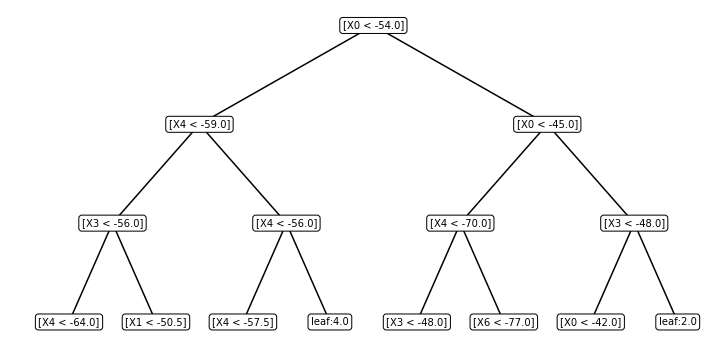

In [18]:
plot_graph(trained_tree_clean_dataset, 3)

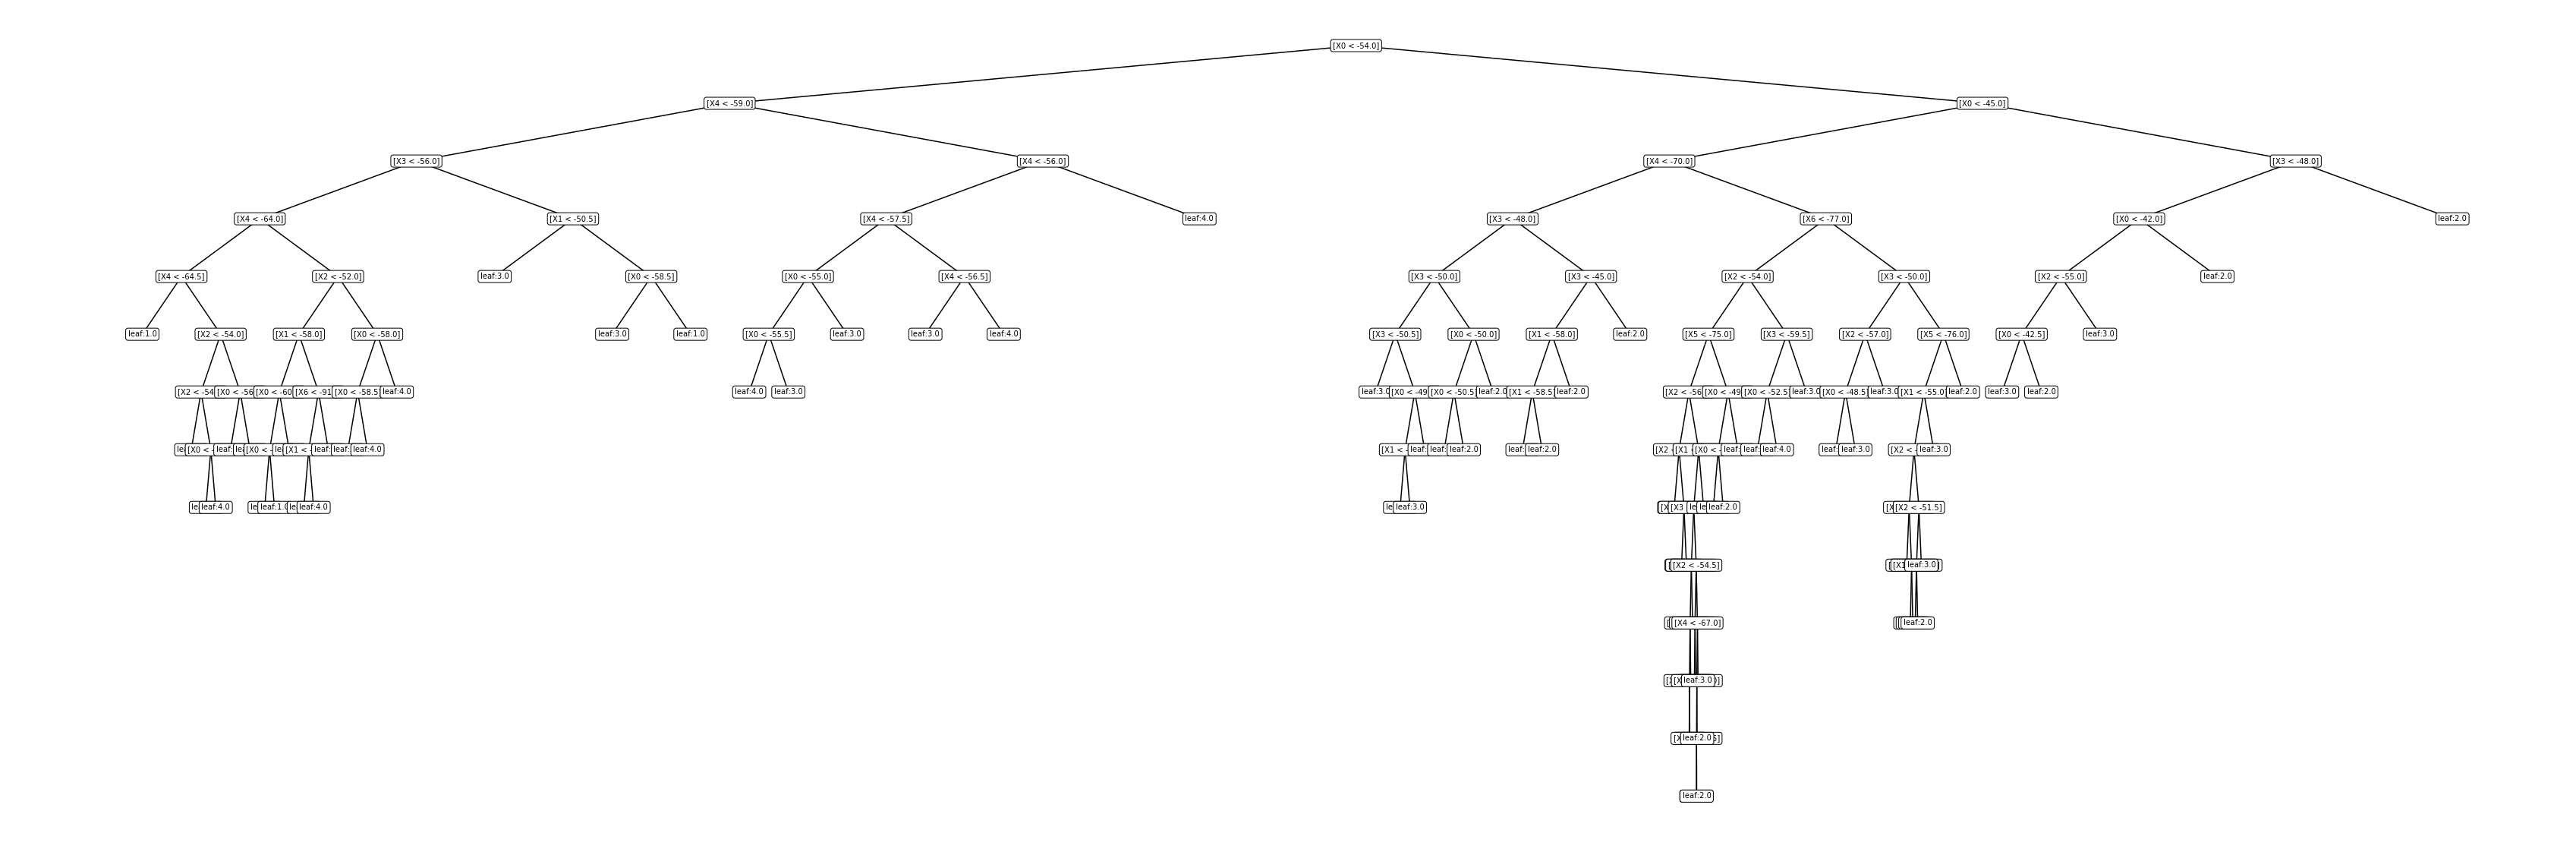

In [19]:
plot_graph(trained_tree_clean_dataset)

We design an evaluation method that will take as inputs a test database and a trained_tree and outputs the label predictions of the model, the true label of the test (will be used to build the confusion matrix) as well as the accuracy of the model.

In [20]:
def evaluate(test_db, trained_tree):
    test_labels = test_db[:, 7]
    test_predictions = np.zeros(len(test_labels))
    for idx, sample in enumerate(test_db):
        node = trained_tree
        leaf = False
        while not leaf:
            attr, val, l_branch, r_branch = node['attr'], node['value'], node['left'], node['right']
            if l_branch == {} and r_branch == {}:
                leaf = True
            else:
                if sample[attr] <= val:
                    node = l_branch
                elif sample[attr] > val:
                    node = r_branch
                else:
                    print("ERROR, can't decide which branch to follow")
        test_predictions[idx] = node['value']
    error = float((((test_labels - test_predictions) != 0).sum()) / len(test_labels))
    accuracy = 1 - error
    return accuracy, test_predictions, test_labels

In [21]:
evaluation = evaluate(noisy_dataset, trained_tree_clean_dataset[0])
print("When putting the noisy dataset samples as test inputs to a decision tree built from the clean dataset, we obtain: ")
print("Label predictions: ")
print(evaluation[1])
print("Accuracy: ")
evaluation[0]

When putting the noisy dataset samples as test inputs to a decision tree built from the clean dataset, we obtain: 
Label predictions: 
[4. 1. 2. ... 1. 3. 3.]
Accuracy: 


0.918

## 10-fold cross validation

The decision tree we have built above is designed to perfectly classify the dataset the data it has been trained on. However, this may lead to overfit, and we would like to be able to split our dataset into a training and a validation dataset, to be able to evaluate how the model generalises. To do so, we will implement a 10-fold cross validation, but first, let's define a few metrics functions.

### Confusion matrix, recall, precision and f1-measure

In [22]:
# Confusion matrix for labels 1, 2, 3, 4.
def confusion_matrix(true_labels, predicted_labels):
    cm = np.zeros((4, 4))
    for c in range(len(true_labels)):
        i, j = int(true_labels[c]), int(predicted_labels[c])
        cm[i-1, j-1] += 1
    return cm

# Takes the confusion matrix as an input and outputs the corresponding recall and precision for each class
def recall_precision(cm):
    nb_classes = cm.shape[0]
    recall = np.zeros(nb_classes)
    precision = np.zeros(nb_classes)
    for idx in range(nb_classes):
        if (idx + 1) < nb_classes:
            false_negative = np.concatenate((cm[idx, :idx], cm[idx, (idx + 1):]))
            false_positive = np.concatenate((cm[:idx, idx], cm[(idx + 1):, idx]))
        else:
            false_negative = cm[idx, :idx]
            false_positive = cm[:idx, idx]
        true_positive = cm[idx, idx]
        recall[idx] = true_positive / (true_positive + false_negative.sum())
        precision[idx] = true_positive / (true_positive + false_positive.sum())
    return recall, precision

# Outputs F1-measure by combining Recall and Precision
def f1_measure(recall, precision):
    f1 = 2 * (recall * precision) / (recall + precision)
    return f1

### 10-fold cross validation algorithm

This algorithm does the following:
- Shuffles the dataset and split it into 10 folds (tuples of the form: (training set, validation set))
- For each fold: 
    - build the tree on the base of the training dataset
    - evaluate de performance of the model on the validation dataset, by outputting the following metrics: the accuracy, the confusion matrix, the recall, precision and f1-measure.
    
Warning : In this version, there is no differentiation between validation and test sets, because we do not tune any parameter based on the result of the validation dataset : the validation dataset is actually a test dataset. In the pruning section, we define a second version of this cross-validation where such a difference is made.

In [23]:
def cross_validation(dataset, folds):
    # Shuffle the dataset
    np.random.shuffle(dataset)
    set_size = int(dataset.shape[0] / folds)   # Warning: choose a fold number which divides the dataset length
    # Creating tuples of (training,testing) folds
    sets = []
    for fold in range(folds):
        testing, training = extract_from_array(dataset, fold * set_size, set_size)
        sets += [(training, testing)]
    # Initialises the array that will contain the metrics of each fold
    results = [0]*folds
    #cm_matrices = np.zeros((4, 4))
    for idx, fold in enumerate(sets):
        trained_tree = decision_tree_learning(fold[0], 0)[0]
        evaluation = evaluate(fold[1], trained_tree)
        accuracy = evaluation[0]
        cm = confusion_matrix(evaluation[2], evaluation[1])
        recall, precision = recall_precision(cm)
        f1 = f1_measure(recall, precision)
        metrics = [accuracy, cm, recall, precision, f1]
        results[idx] = metrics
    return results

In [24]:
cv = cross_validation(dataset, 10)
print("The metrics on the first fold are :")
print("Accuracy : ", cv[0][0])
print("Confusion matrix : ", cv[0][1])
print("Recall for each class : ", cv[0][2])
print("Precision for each class : ", cv[0][3])
print("F1 for each class : ", cv[0][4])

The metrics on the first fold are :
Accuracy :  0.96
Confusion matrix :  [[39.  0.  0.  0.]
 [ 0. 44.  3.  0.]
 [ 0.  3. 49.  1.]
 [ 1.  0.  0. 60.]]
Recall for each class :  [1.         0.93617021 0.9245283  0.98360656]
Precision for each class :  [0.975      0.93617021 0.94230769 0.98360656]
F1 for each class :  [0.98734177 0.93617021 0.93333333 0.98360656]


Let's now define a small function that will digest the exhaustive results from cross-validation

In [36]:
def analyse_metrics(cv_results, folds):
    accuracies, recall, precision, f1 = np.zeros(folds), np.zeros((folds,4)), np.zeros((folds,4)), np.zeros((folds,4))
    sum_cm = np.zeros((4,4))
    for i in range(folds):
        sum_cm += cv_results[i][1] # Element wise sum of all confusion matrices
        accuracies[i], recall[i], precision[i], f1[i] = cv_results[i][0], cv_results[i][2], cv_results[i][3], cv_results[i][4]
    mean_accuracy = accuracies.mean()
    dataset_size = sum_cm.sum()
    mean_cm = sum_cm.astype(float)/dataset_size
    mean_recall, mean_precision, mean_f1 = recall.mean(0), precision.mean(0), f1.mean(0)
    return mean_accuracy, mean_cm, mean_recall, mean_precision, mean_f1, sum_cm

analyse_metrics(cv, 10)

(0.966, array([[0.2465, 0.    , 0.001 , 0.0025],
        [0.    , 0.2395, 0.0105, 0.    ],
        [0.002 , 0.0125, 0.234 , 0.0015],
        [0.002 , 0.    , 0.002 , 0.246 ]]), array([0.98519118, 0.95799341, 0.93691846, 0.98370554]), array([0.98445139, 0.95063586, 0.94752044, 0.98469533]), array([0.98464453, 0.95384369, 0.94155751, 0.98410493]), array([[493.,   0.,   2.,   5.],
        [  0., 479.,  21.,   0.],
        [  4.,  25., 468.,   3.],
        [  4.,   0.,   4., 492.]]))

## Code to answer questions from step 3:

1. Run 10-fold cross validation on the previous trees

In [41]:
cv_clean = cross_validation(dataset, 10)
cv_noisy = cross_validation(noisy_dataset, 10)

Compute the means from the raw results obtained on the 10 fold cross validation

In [27]:
metrics_clean_tree = analyse_metrics(cv_clean, 10)
metrics_noisy_tree = analyse_metrics(cv_noisy, 10)

### From above, we have :

The mean confusion matrix for each dataset (the number are percentages of the validation dataset):

In [28]:
print("For clean dataset :")
print(metrics_clean_tree[1]*100,"\n")
print("For noisy dataset :")
print(metrics_noisy_tree[1]*100)

For clean dataset :
[[24.5   0.    0.15  0.35]
 [ 0.   24.1   0.9   0.  ]
 [ 0.25  0.6  24.1   0.05]
 [ 0.15  0.    0.25 24.6 ]] 

For noisy dataset :
[[20.45  1.    1.15  1.9 ]
 [ 1.5  20.5   1.85  1.  ]
 [ 1.1   1.65 21.2   1.8 ]
 [ 1.65  1.15  1.85 20.25]]


Same as above but not in percentages:

In [29]:
print("For clean dataset :")
print(metrics_clean_tree[5],"\n")
print("For noisy dataset :")
print(metrics_noisy_tree[5])

For clean dataset :
[[490.   0.   3.   7.]
 [  0. 482.  18.   0.]
 [  5.  12. 482.   1.]
 [  3.   0.   5. 492.]] 

For noisy dataset :
[[409.  20.  23.  38.]
 [ 30. 410.  37.  20.]
 [ 22.  33. 424.  36.]
 [ 33.  23.  37. 405.]]


Average recall and precision rates per class :

In [30]:
print("For clean dataset :")
print("Recall : ", metrics_clean_tree[2],"\n","Precision : ", metrics_clean_tree[3],"\n")
print("For noisy dataset :")
print("Recall : ", metrics_noisy_tree[2],"\n","Precision : ", metrics_noisy_tree[3])

For clean dataset :
Recall :  [0.98029625 0.96412966 0.96495405 0.98327699] 
 Precision :  [0.98361242 0.97557349 0.9490814  0.98380714] 

For noisy dataset :
Recall :  [0.83116198 0.82285153 0.82498049 0.81336989] 
 Precision :  [0.82336121 0.8443979  0.81571823 0.81293093]


F1 measures derived from the results above:

In [31]:
print("F1 measure for clean dataset :")
print(metrics_clean_tree[4],"\n")
print("F1 measure for noisy dataset :")
print(metrics_noisy_tree[4])

F1 measure for clean dataset :
[0.98182717 0.96941859 0.95660768 0.98348331] 

F1 measure for noisy dataset :
[0.82606195 0.83215268 0.81831036 0.81207255]


## Step 4: pruning

For the pruning, we will need the following sub functions to execute the traversal of the decision tree.

In [32]:
# Creates a new tree with a pair of leaves merged according to a path 
def change_node(node, path, value):
    # Last node in the path
    if len(path) == 1:
        return {'attr' : 'leaf', 'value': value, 'left': {}, 'right': {}}
    
    # Other nodes
    else:
        direction = path.pop()[2] # Removes a node from the path
        if direction == 'left':
            return {'attr' : node['attr'], 'value': node['value'], 
                    'left': change_node(node[direction], path, value), 'right': node['right']}
        else:
            return {'attr' : node['attr'], 'value': node['value'], 
                    'left': node['left'], 'right': change_node(node[direction], path, value)}


def merge_some_leaves(tree, rev_path, value):
    new_tree = tree.copy()
    path = rev_path[::-1] # Reversed path for the change_node function
    new_tree = change_node(new_tree, path, value)
    return new_tree

In [33]:
# Compares the performance of two trees on the test dataset and returns the best tree
def compare_trees(test_db, original_tree, new_tree):
    error_init = 1 - evaluate(test_db, original_tree)[0] # error = 1 - accuracy
    error = 1 - evaluate(test_db, new_tree)[0]
    # Compare the "new" error with the initial one
    if error < error_init:
        return new_tree
    else:
        return original_tree

Using the previous functions, we can build the pruning algorithm. The main idea is to do for each node with two leaves the following tasks: to create a new tree where those two leaves are merged, to compare the performance of the original and the new trees on a validation set, and to keep the best tree.

In [34]:
# Returns a pruned tree according to the test dataset
def pruning(test_db, tree):
    whole_tree_copy = tree.copy() # Prevent the overwriting of the original decision tree
    node, path, prun_tree = pruning_aux(whole_tree_copy, [], whole_tree_copy, test_db)
    return prun_tree

def pruning_aux(node, path, whole_tree, test_data):
    # Leaf
    if node['attr'] == 'leaf':
        return node, path, whole_tree
    
    # Node
    else:
        path += [(node['attr'], node['value'], 'left')] # Track the current node
        
        # Prevent the overwriting of the node and the tree
        updated_node = node.copy() 
        updated_tree = whole_tree.copy()
        
        # Treat the left branch
        updated_node['left'], path, updated_tree = pruning_aux(updated_node['left'], path, updated_tree, test_data)
        
        # Change the path to go on the right branch
        path.pop()
        path += [(node['attr'], node['value'], 'right')]
        
        # Treat the right branch
        updated_node['right'], path, updated_tree = pruning_aux(updated_node['right'], path, updated_tree, test_data)
        
        # If there are two leaves under the current node
        if (updated_node['left']['attr'] == 'leaf') and (updated_node['right']['attr'] == 'leaf'):
            labels = [updated_node['left']['value'], updated_node['right']['value']] # The two possible labels for the node
            
            # Test the performance of a new tree with one of the two possible labels
            new_tree1 = merge_some_leaves(updated_tree, path, labels[0])
            new_tree2 = merge_some_leaves(updated_tree, path, labels[1])
            tree1 = compare_trees(test_data, updated_tree, new_tree1)
            tree2 = compare_trees(test_data, updated_tree, new_tree2)
            tree = compare_trees(test_data, tree1, tree2) # Return the best tree among the initial tree and the two possible new trees
            
            # If merging the two leaves is better for the accuracy
            if tree != updated_tree:
                if tree == tree1:
                    label = labels[0]
                else:
                    label = labels[1]
                
                # Update the current node and the overall tree with the new tree
                updated_node = {'attr' : 'leaf', 'value': label, 'left': {}, 'right': {}}
                updated_tree = tree.copy()
        
        # The node has been treated and we go back to the parent node
        path.pop()        
        return updated_node, path, updated_tree

In [38]:
# The noisy dataset as a training dataset
tree_example = decision_tree_learning(noisy_dataset, 0)[0]
new_tree = pruning(dataset, tree_example)

print('accuracy before pruning:', evaluate(dataset, tree_example)[0])
print('accuracy after pruning:', evaluate(dataset, new_tree)[0])

accuracy before pruning: 0.918
accuracy after pruning: 0.9785


In [39]:
# The clean dataset as a training dataset
tree_example = decision_tree_learning(dataset, 0)[0]
new_tree = pruning(noisy_dataset, tree_example)

print('accuracy before pruning:', evaluate(noisy_dataset, tree_example)[0])
print('accuracy after pruning:', evaluate(noisy_dataset, new_tree)[0])

accuracy before pruning: 0.918
accuracy after pruning: 0.918


In [40]:
# Depth pruned tree
def depth_tree(tree):
    return depth_tree_aux(tree, 0)
    
def depth_tree_aux(node, depth):
    # Leaf
    if node['attr'] == 'leaf':
        return depth
    # Node
    else:
        depth_left = depth_tree_aux(node['left'], depth + 1)
        depth_right = depth_tree_aux(node['right'], depth + 1)
        return max(depth_left, depth_right)
    
print(depth_tree(new_tree))

13


### Second version of 10-fold cross validation, where we differentiate the training, validation and test datasets.

As an option, depending on the time available, one can choose to set "all_combination" to True of False. If set to True, the algorithm run all possible combinations of test/validation and training dataset (i.e 10 test datasets and the corresponding 9*10=90 trees). If set to False, only one sample is run (the first one).

In [56]:
def separate_dataset(dataset, folds):
    output = []
    np.random.shuffle(dataset)
    set_size = int(dataset.shape[0] / folds)   # Warning: choose a fold number which divides the dataset length
    for fold in range(folds):
        test_data, train_val = extract_from_array(dataset, fold * set_size, set_size)
        sub_fold_data = []
        for sub_fold in range(folds - 1):
            validation_data, training_data = extract_from_array(train_val, sub_fold * set_size, set_size)
            sub_fold_data.append([training_data, validation_data])
        fold_data = [test_data, sub_fold_data]
        output.append(fold_data)
    return output

# Inputs : dataset to train and evaluate decision_tree on
# Inputs : number of folds (10 for 10-folds cross validation)
# Inputs : all_combination : True if train and test on all possible combinations (i.e 90 trees for 10 fold cross)
#                            False if split the dataset only once (i.e in 1 test dataset and 9 trees for 10 fold)
# Outputs: Matrix of accuracies with and without pruning on the format (Fold x Sub_Fold x 2)
def cross_validation_pruning(dataset, folds, all_combination = True):
    # Creating lists of (training, validation, testing) folds
    test_train_val = separate_dataset(dataset, folds)
    # Prepare the matrix that will contain the results
    if all_combination:
        results = np.zeros((folds, folds-1, 2))
        depth = np.zeros((folds, folds-1, 2))
    else:
        results = np.zeros((folds-1,2))
        depth = np.zeros((folds-1,2))
    #cm_matrices = np.zeros((4, 4))

    for idx, fold in enumerate(test_train_val):
        if not all_combination and idx != 0:
            continue
        test_data = fold[0]
        training_validation = fold[1]
        for sub_idx, sub_fold in enumerate(training_validation):
            training_data = sub_fold[0]
            validation_data = sub_fold[1]
            # Now that the 3 dataset are clearly separated, let's train the tree
            trained_tree = decision_tree_learning(training_data, 0)[0]
            # Now let's prune it using the validation dataset to tune the pruning
            pruned_tree = pruning(validation_data, trained_tree)
            # We evaluate the accuracy before and after pruning
            acc_noprun, acc_prun = evaluate(test_data, trained_tree)[0], evaluate(test_data, pruned_tree)[0]
            depth_noprun, depth_prun = decision_tree_learning(training_data, 0)[1], depth_tree(pruned_tree)
            # Store the results
            if all_combination:
                results[idx, sub_idx] = np.array([acc_noprun, acc_prun])
                depth[idx, sub_idx] = np.array([depth_noprun, depth_prun])
            else:
                results[sub_idx] = np.array([acc_noprun, acc_prun])
                depth[sub_idx] = np.array([depth_noprun, depth_prun])
            print("Done with Test ", idx, ".", sub_idx)
        print("--------- Done with fold #", idx)
        
    return results, depth

In [63]:
results, depth = cross_validation_pruning(noisy_dataset, 10, all_combination = True)

Done with Test  0 . 0
Done with Test  0 . 1
Done with Test  0 . 2
Done with Test  0 . 3
Done with Test  0 . 4
Done with Test  0 . 5
Done with Test  0 . 6
Done with Test  0 . 7
Done with Test  0 . 8
--------- Done with fold # 0


KeyboardInterrupt: 

In [ ]:
print("Mean of accuracy before pruning: ",results.mean(0).mean(0)[0])
print("Mean of accuracy after pruning: ",results.mean(0).mean(0)[1])

In [ ]:
print("Mean of depth before pruning: ", depth.mean(0)[0])
print("Mean of depth after pruning: ", depth.mean(0)[1])

In [61]:
results, depth = cross_validation_pruning(dataset, 10, all_combination = False)

Done with Test  0 . 0
Done with Test  0 . 1
Done with Test  0 . 2
Done with Test  0 . 3
Done with Test  0 . 4
Done with Test  0 . 5
Done with Test  0 . 6
Done with Test  0 . 7
Done with Test  0 . 8
--------- Done with fold # 0


In [62]:
print("Mean of depth before pruning: ", depth.mean(0)[0])
print("Mean of depth after pruning: ", depth.mean(0)[1])

Mean of depth before pruning:  12.88888888888889
Mean of depth after pruning:  12.777777777777779
